<a href="https://colab.research.google.com/github/vekoada/tensorflow-course/blob/main/07_project_1_food_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To use mixed-precision training, we need a GPU with compute capability greater than 7.0. Thankfully, the Tesla T4 is rated 7.5

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8dcac1ca-a59d-c3b8-fc4f-d884693ea936)


In [ ]:
# Download file with helper functions
!wget https://raw.githubusercontent.com/vekoada/tensorflow-course/main/helper_functions.py

--2023-09-24 16:21:55--  https://raw.githubusercontent.com/vekoada/tensorflow-course/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6734 (6.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-09-24 16:21:55 (70.0 MB/s) - ‘helper_functions.py’ saved [6734/6734]



In [ ]:
#Import tensorboard callback creator, loss plotting, and comparison of history
from helper_functions import tensorboard, plot_loss, compare_histories

Instead of the preprocessed data from before, this project will import from TensorFlow Datasets (TFDS)

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
#Check if Food 101 is in tfds (it is)
print('food101' in tfds.list_builders())

True


In [ ]:
#Data load from tfds
#This takes ~10 minutes due to size
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete638PWC/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete638PWC/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
#Check features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

Find out:
- Class names
- Input shape
- Input dtype
- Label type (one-hot, label encoded?)
- Whether labels match class names

In [ ]:
#View first 10 class names (located in ds_info)
class_names = ds_info.features['label'].names
class_names[:10], len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)

In [ ]:
#Look at 1 sample from the training data
sample = train_data.take(1) #format is (image_tensor, label)
sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#Display info
for image, label in sample:
  print(f"""
  Image shape: {image.shape},
  Image dtype: {image.dtype},
  Class (int): {label},
  Class name (str): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image dtype: <dtype: 'uint8'>,
  Class (int): 1,
  Class name (str): baby_back_ribs
  


In [ ]:
#View image tensor
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 95,  95,  25],
        [ 87,  87,  17],
        [ 96,  93,  26],
        ...,
        [178, 189, 191],
        [180, 191, 193],
        [178, 189, 191]],

       [[ 92,  92,  22],
        [ 86,  86,  16],
        [ 91,  88,  21],
        ...,
        [183, 194, 196],
        [184, 195, 197],
        [180, 191, 193]],

       [[ 97,  94,  25],
        [ 92,  89,  20],
        [ 89,  86,  19],
        ...,
        [187, 198, 200],
        [185, 199, 200],
        [181, 195, 196]],

       ...,

       [[205, 196, 155],
        [205, 196, 155],
        [203, 194, 155],
        ...,
        [216, 228, 226],
        [214, 226, 224],
        [207, 219, 217]],

       [[209, 197, 155],
        [210, 198, 156],
        [207, 198, 159],
        ...,
        [216, 228, 226],
        [212, 224, 222],
        [212, 224, 222]],

       [[202, 191, 146],
        [207, 195, 153],
        [207, 198, 157],
        ...,
        [217, 229, 22

In [ ]:
import tensorflow as tf

In [ ]:
#Find min and max of values -- what to scale by
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'baby_back_ribs, class 1')

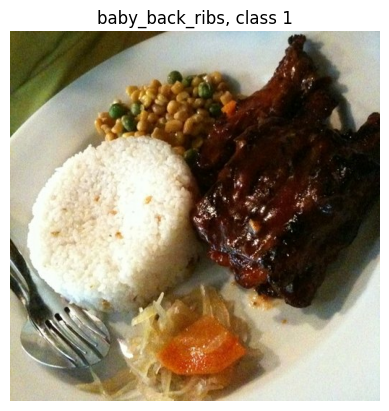

In [ ]:
#Plot an image as an example
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis(False)
plt.title(f"{class_names[label.numpy()]}, class {label}")

The images aren't all the same size/shape. Some preprocessing is necessary before training. image_dataset_from_directory won't work - we will have to reshape and batch.

State of the data:
- `uint8` dtype
- different sizes
- unscaled (0-255)

Goal state:
- `float32` and `float64` dtypes for mixed precision
-reshape into same size
- scaled (0-1)

Since we're using EfficientNet, we don't need to rescale. The architecture includes a built-in rescaling layer

In [ ]:
#The preprocessing function
def process_image(image: tf.Tensor, label: int, target_shape: int=224, scale: bool=False) -> tf.Tensor:
  """
  Converts image tensor to shape [target_shape, target_shape, color_channels] and datatype to float32.

  Args:
    image (tf.Tensor): The image tensor that needs to be converted.
    label (int): The ground-truth label of the image.
    target_shape (int): The desired shape of the tensor [target_shape, target_shape] (default is 224).
    scale (bool): Whether to scale the values between 0 and 1 (default is True)

  Returns:
    (tf.Tensor, int): A tuple containing the resized float32 image and its label
  """

  image = tf.image.resize(image, [target_shape, target_shape]) #resize the image to 'square' tensor

  if scale:
    image /= 255. #Scale the values if specified

  return tf.cast(image, tf.float32), label #return tuple with float32-casted image and label

In [ ]:
#Process and review example
processed_image = process_image(image=image, label=label)[0]
print(f"Original dtype, shape: {image.dtype}, {image.shape}\n New dtype, shape: {processed_image.dtype}, {processed_image.shape}")

Original dtype, shape: <dtype: 'uint8'>, (512, 512, 3)
 New dtype, shape: <dtype: 'float32'>, (224, 224, 3)


Visit [tensorflow documentation](https://www.tensorflow.org/guide/data_performance) more information on the batching, fetching

In [ ]:
#Now for batch preprocessing
#Map preprocessing function to training data and parallizes
train_data = train_data.map(map_func=process_image, num_parallel_calls=tf.data.AUTOTUNE)

#Shuffle the data and batch, prefetch
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#Map preprocessing function to test data & parallize
test_data = test_data.map(map_func=process_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
#Model checkpoint
path = 'model_checkpoints/cp.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(path,
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=0)

[Mixed precision training documentation](https://www.tensorflow.org/guide/mixed_precision)
- Note: We must specify the dtype of the output layer to be float32 for numeric stability. Read the documentation for more information.



In [ ]:
#Activate mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
#Build feature extraction model

input_shape = (224, 224, 3)

#Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create functional model
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer') #Can follow with a rescaling layer for bases that don't have it
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
#Compile the model: our labels are integers, so use sparse cross entropy
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
for layer in model.layers:
  print(layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

input_layer float32 <Policy "float32"> True
efficientnetb0 float32 <Policy "mixed_float16"> False
global_average_pooling2d float32 <Policy "mixed_float16"> True
dense float32 <Policy "mixed_float16"> True
softmax_float32 float32 <Policy "float32"> True


In [ ]:
for layer in model.layers[1].layers[-15:]: #checking efficientnet's dtype policy
  print(layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

block7a_expand_bn float32 <Policy "mixed_float16"> False
block7a_expand_activation float32 <Policy "mixed_float16"> False
block7a_dwconv float32 <Policy "mixed_float16"> False
block7a_bn float32 <Policy "mixed_float16"> False
block7a_activation float32 <Policy "mixed_float16"> False
block7a_se_squeeze float32 <Policy "mixed_float16"> False
block7a_se_reshape float32 <Policy "mixed_float16"> False
block7a_se_reduce float32 <Policy "mixed_float16"> False
block7a_se_expand float32 <Policy "mixed_float16"> False
block7a_se_excite float32 <Policy "mixed_float16"> False
block7a_project_conv float32 <Policy "mixed_float16"> False
block7a_project_bn float32 <Policy "mixed_float16"> False
top_conv float32 <Policy "mixed_float16"> False
top_bn float32 <Policy "mixed_float16"> False
top_activation float32 <Policy "mixed_float16"> False


In [ ]:
#Fit the feature extraction model
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.1*len(test_data)),
                    callbacks=[tensorboard(dir_name='training_logs',
                                                       experiment_name='efficientnetb0_feature_extraction_food_101'),
                               checkpoint])

Saving TensorBoard log files to training_logs/efficientnetb0_feature_extraction_food_101/20230924-165015
Epoch 1/3
2368/2368 [==============================] - 203s 79ms/step - loss: 1.7161 - accuracy: 0.5829 - val_loss: 1.1515 - val_accuracy: 0.6938
Epoch 2/3
2368/2368 [==============================] - 204s 84ms/step - loss: 1.1997 - accuracy: 0.6892 - val_loss: 1.0484 - val_accuracy: 0.7168
Epoch 3/3
2368/2368 [==============================] - 229s 95ms/step - loss: 1.0532 - accuracy: 0.7255 - val_loss: 1.0191 - val_accuracy: 0.7211


In [ ]:
results = model.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 1.0051 - accuracy: 0.7264


In [ ]:
model.save('feature_extractor.keras')

In [ ]:
loaded_model = tf.keras.models.load_model('feature_extractor.keras')

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
loaded_results = loaded_model.evaluate(test_data)
loaded_results

790/790 [==============================] - 54s 64ms/step - loss: 1.0051 - accuracy: 0.7264


[1.0051450729370117, 0.7264158129692078]

In [ ]:
loaded_model.trainable = True

In [ ]:
for layer in loaded_model.layers:
  print(layer.name, layer.dtype_policy, layer.trainable)

input_layer <Policy "float32"> True
efficientnetb0 <Policy "mixed_float16"> True
global_average_pooling2d <Policy "mixed_float16"> True
dense <Policy "mixed_float16"> True
softmax_float32 <Policy "float32"> True


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
stop_early = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True)

In [ ]:
path = 'finetune_checkpoints/cp.ckpt'
fine_tune_checkpoint = tf.keras.callbacks.ModelCheckpoint(path,
                                                monitor='val_loss',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=0)

In [ ]:
loaded_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy'])

In [ ]:
loaded_model.fit(train_data,
                 epochs=100,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=int(0.07*len(test_data)),
                 callbacks=[tensorboard(dir_name='training_logs',
                                        experiment_name='efficientnetb0_fine_tune_food_101'),
                            fine_tune_checkpoint,
                            stop_early])

Saving TensorBoard log files to training_logs/efficientnetb0_fine_tune_food_101/20230924-171515
Epoch 1/100
2368/2368 [==============================] - 434s 157ms/step - loss: 0.8690 - accuracy: 0.7651 - val_loss: 0.7926 - val_accuracy: 0.7864
Epoch 2/100
2368/2368 [==============================] - 359s 150ms/step - loss: 0.5370 - accuracy: 0.8511 - val_loss: 0.7825 - val_accuracy: 0.7898
Epoch 3/100
2368/2368 [==============================] - 356s 149ms/step - loss: 0.3041 - accuracy: 0.9136 - val_loss: 0.8340 - val_accuracy: 0.7875
Epoch 4/100
2368/2368 [==============================] - 358s 150ms/step - loss: 0.1598 - accuracy: 0.9528 - val_loss: 1.0055 - val_accuracy: 0.7705
Epoch 5/100
2368/2368 [==============================] - 380s 159ms/step - loss: 0.1012 - accuracy: 0.9679 - val_loss: 1.0595 - val_accuracy: 0.7858


In [ ]:
loaded_model.save('fine_tuned_efficientnetb0.keras')

In [ ]:
#Evaluate the model on the full test data
loaded_model.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 0.7634 - accuracy: 0.7914


[0.7633970379829407, 0.7914455533027649]

Nice! 79.14% accuracy - that beats the DeepFood paper from 2016.

Note: I forgot to save the training loop to a history variable and can't plot the results. However, the log should be in our TensorBoard!

In [ ]:
#Predict with the model
prediction_probs = loaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 57s 70ms/step


In [ ]:
#Observe the shape of the results
len(prediction_probs), prediction_probs.shape

(25250, (25250, 101))

In [ ]:
#Look at the first result
prediction_probs[0], len(prediction_probs[0])

(array([4.9448613e-06, 2.9633833e-08, 5.6117027e-09, 3.2801658e-08,
        6.9295281e-09, 7.7793584e-06, 5.7240931e-07, 1.5583136e-09,
        3.0528525e-05, 1.3075059e-07, 2.9465102e-07, 1.9698929e-09,
        1.4137511e-07, 4.2537840e-07, 3.5488239e-04, 4.5349507e-10,
        1.6853055e-01, 4.5994375e-07, 4.7525878e-10, 4.8375903e-09,
        6.3094068e-09, 1.6029467e-03, 5.5613171e-04, 1.2212946e-06,
        5.8598351e-07, 2.5293927e-09, 4.0822325e-08, 1.5323039e-04,
        2.3259860e-08, 5.3334166e-03, 7.2773666e-08, 2.0135742e-06,
        5.8229926e-10, 1.8322859e-10, 6.1762208e-08, 1.3673768e-08,
        9.6062249e-06, 7.9304243e-08, 9.1801331e-09, 1.1473001e-06,
        3.5745227e-08, 3.2361083e-07, 9.0949916e-06, 1.1830127e-10,
        2.1758934e-10, 3.2870699e-07, 8.3110130e-08, 1.1271407e-07,
        5.2306821e-09, 7.7026078e-07, 1.2992851e-10, 5.5797507e-08,
        7.6864318e-08, 2.9929112e-07, 1.8427784e-11, 9.2188151e-07,
        1.3918329e-07, 1.1904978e-07, 4.0286046e

In [ ]:
#Upload results to TensorBoard
!tensorboard dev upload --logdir ./training_logs \
--name "Fine-tuning EfficientNetB0 on all Food101 Data" \
--description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
--one_shot

2023-09-24 18:11:03.642497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 18:11:05.824080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-24 18:11:09.207408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 18:11:09.783333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Evidently, the model was severly overfitted to the training data. The following link contains the experiment: https://tensorboard.dev/experiment/tvdj5K01SKSNmVApyswX6w/

Note: I will have to add the ReduceLROnPlateau callback, create the confusion matrix. To create the confusion matrix, I will need to not shuffle the test data. Since it is shuffled, I can't identify any meaningful metrics at the moment. Maybe I'll come back to this and rerun the whole notebook (which will take 45+ minutes, but could be interesting to see if reducing the learning rate on plateau provides any improvement.  